
[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
^C
Traceback (most recent call last):
  File "/root/venv/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
  File "/root/venv/lib/python3.9/site-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/root/venv/lib/python3.9/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/root/venv/lib/python3.9/site-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/root/venv/lib/python3.9/site-packages/pip/_internal/build_env.py", line 21, in <module>
    from pip._internal.metadata import get_default_environment, get_environment
  File "/root/venv/lib/python3.9/site-packages/pip/_internal/metadata/__init__.py", line 9, 

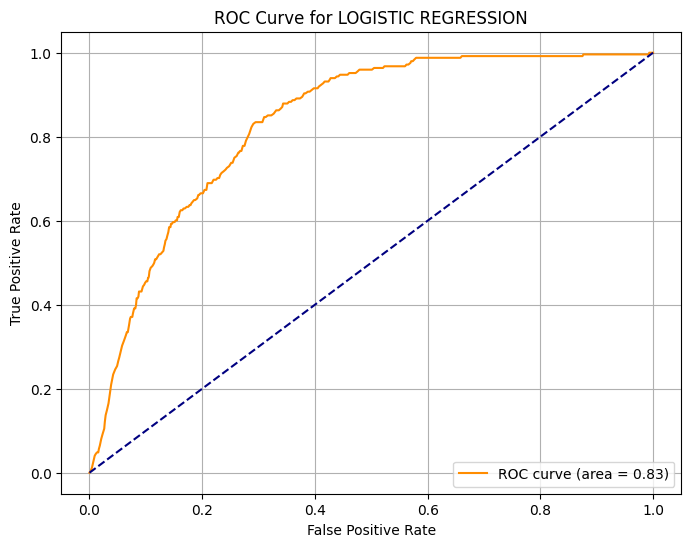

In [1]:
# Installing Imbalanced Learn
!pip install imblearn
!pip install catboost

import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
                             roc_curve, roc_auc_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline

# Load dataset
path = "/work/stroke_dataset.csv"
df = pd.read_csv(path)

# Features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Define features
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numeric_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

# Pre-processing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

models = {
    "LOGISTIC REGRESSION": LogisticRegression(C=0.001, penalty='l1', solver='liblinear', max_iter=1000000),
}

def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def evaluate_and_save_models(models, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    smote = SMOTE(random_state=42)

    for model_name, model in models.items():
        print(f"\n{model_name}:\n{'=' * len(model_name)}\n")
        
        # Combined pipeline for training (with SMOTE)
        train_pipeline = make_imb_pipeline(preprocessor, smote, model)
        
        # Pipeline for saving (without SMOTE) - just preprocessing and model
        save_pipeline = make_imb_pipeline(preprocessor, model)

        metrics_df = pd.DataFrame(columns=["Fold", "Accuracy", "Recall", "Precision", "F1 Score"])
        train_metrics_df = pd.DataFrame(columns=["Fold", "Accuracy", "Recall", "Precision", "F1 Score"])
        aggregated_cm = None  # Aggregated confusion matrix
        aggregated_y_true = []
        aggregated_y_scores = []

        for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
            X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
            X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]

            train_pipeline.fit(X_train_fold, y_train_fold)
            
            y_train_pred = train_pipeline.predict(X_train_fold)
            train_accuracy = accuracy_score(y_train_fold, y_train_pred)
            train_recall = recall_score(y_train_fold, y_train_pred)
            train_precision = precision_score(y_train_fold, y_train_pred)
            train_f1 = f1_score(y_train_fold, y_train_pred)
            train_metrics_df.loc[fold-1] = [f"Fold {fold}", train_accuracy, train_recall, train_precision, train_f1]

            y_val_pred = train_pipeline.predict(X_val_fold)
            y_val_scores = train_pipeline.predict_proba(X_val_fold)[:, 1]
            accuracy = accuracy_score(y_val_fold, y_val_pred)
            recall = recall_score(y_val_fold, y_val_pred)
            precision = precision_score(y_val_fold, y_val_pred)
            f1 = f1_score(y_val_fold, y_val_pred)
            cm = confusion_matrix(y_val_fold, y_val_pred)

            if aggregated_cm is None:
                aggregated_cm = cm
            else:
                aggregated_cm += cm

            metrics_df.loc[fold-1] = [f"Fold {fold}", accuracy, recall, precision, f1]
            aggregated_y_true.extend(y_val_fold)
            aggregated_y_scores.extend(y_val_scores)

        print("Validation Metrics:")
        print(metrics_df.to_string(index=False))
        print("\nTraining Metrics:")
        print(train_metrics_df.to_string(index=False))
        
        print("\nSummary for", model_name)
        print("Average Validation Accuracy:", metrics_df["Accuracy"].mean())
        print("Average Validation Recall:", metrics_df["Recall"].mean())
        print("Average Validation Precision:", metrics_df["Precision"].mean())
        print("Average Validation F1 Score:", metrics_df["F1 Score"].mean())
        
        print("\nAverage Training Accuracy:", train_metrics_df["Accuracy"].mean())
        print("Average Training Recall:", train_metrics_df["Recall"].mean())
        print("Average Training Precision:", train_metrics_df["Precision"].mean())
        print("Average Training F1 Score:", train_metrics_df["F1 Score"].mean())

        print("\nAggregated Confusion Matrix:")
        print(f"TN: {aggregated_cm[0][0]}, FP: {aggregated_cm[0][1]}")
        print(f"FN: {aggregated_cm[1][0]}, TP: {aggregated_cm[1][1]}\n\n")

        plot_roc_curve(aggregated_y_true, aggregated_y_scores, model_name)

        with open(f"{model_name}_modified.pickle", 'wb') as model_file:
            pickle.dump(save_pipeline, model_file)

evaluate_and_save_models(models, X, y)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=311bc360-0ff3-42ad-8fe8-990672a12326' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>